*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*

Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

# Ch02 - The Perceptron

## Hands-on Section

###  Table of Contents
* [Preparing the Dataset](#Preparing-the-Dataset)
* [Implementing a Perceptron in NumPy](#Implementing-a-Perceptron-in-NumPy)
* [Implementing a Perceptron in TensorFlow](#Implementing-a-Perceptron-in-TensorFlow)


In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -d -p tensorflow,numpy,matplotlib

Sebastian Raschka 2017-03-31 

tensorflow 1.0.1
numpy 1.12.1
matplotlib 2.0.0


In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

## Preparing the Dataset

- Load dataset from tab-seperated text file
- Dataset contains three columns: feature 1, feature 2, and class labels
- Dataset contains 100 entries sorted by class labels, 50 examples from each class

Class label counts: [50 50]


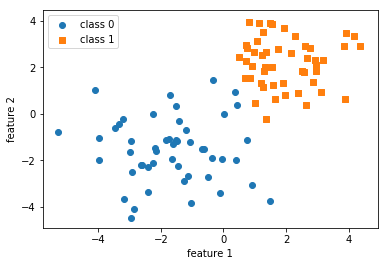

In [4]:
data = np.genfromtxt('perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))

plt.scatter(X[y==0, 0], X[y==0, 1], label='class 0', marker='o')
plt.scatter(X[y==1, 0], X[y==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

- Shuffle dataset
- Split dataset into 70% training and 30% test data
- Seed random number generator for reproducibility

In [5]:
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

- Standardize training and test datasets (mean zero, unit variance)

In [6]:
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

- Check dataset (here: training dataset) after preprocessing steps

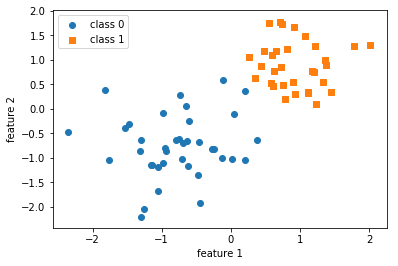

In [7]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Implementing a Perceptron in NumPy

- Implement function for perceptron training in NumPy

In [8]:
def perceptron_train(features, targets, mparams=None,
                     zero_weights=True, learning_rate=1., seed=None):
    """Perceptron training function for binary class labels

    Parameters
    ----------
    features : numpy.ndarray, shape=(n_samples, m_features)
        A 2D NumPy array containing the training examples

    targets : numpy.ndarray, shape=(n_samples,)
        A 1D NumPy array containing the true class labels

    mparams : dict or None (default: None)
        A dictionary containing the model parameters, for instance
        as returned by this function. If None, a new model parameter
        dictionary is initialized. Note that the values in mparams
        are updated inplace if a mparams dict is provided.

    zero_weights : bool (default: True)
        Initializes weights to all zeros, otherwise model weights are
        initialized to small random number from a normal distribution
        with mean zero and standard deviation 0.1.

    learning_rate : float (default: 1.0)
        A learning rate for the parameter updates. Note that a learning
        rate has no effect on the direction of the decision boundary
        if if the model weights are initialized to all zeros.

    seed : int or None (default: None)
        Seed for the pseudo-random number generator that initializes the
        weights if zero_weights=False

    Returns
    -------
    mparams : dict
        The model parameters after training the perceptron for one epoch.
        The mparams dictionary has the form:
        {'weights': np.array([weight_1, weight_2, ... , weight_m]),
         'bias': np.array([bias])}

    """
    # initialize model parameters
    if mparams is None:
        mparams = {'bias': np.zeros(1)}
        if zero_weights:
            mparams['weights'] = np.zeros(features.shape[1])
        else:
            rng = np.random.RandomState(seed)
            mparams['weights'] = rng.normal(loc=0.0, scale=0.1,
                                           size=(features.shape[1]))

    # train one epoch
    for training_example, true_label in zip(features, targets):
        linear = np.dot(training_example, mparams['weights']) + mparams['bias']

        # if class 1 was predicted but true label is 0
        if linear > 0. and not true_label:
            mparams['weights'] -= learning_rate * training_example
            mparams['bias'] -= learning_rate * 1.

        # if class 0 was predicted but true label is 1
        elif linear <= 0. and true_label:
            mparams['weights'] += learning_rate * training_example
            mparams['bias'] += learning_rate * 1.

    return mparams

- Train the perceptron for 2 epochs

In [9]:
model_params = perceptron_train(X_train, y_train, 
                                mparams=None, zero_weights=True)

for _ in range(2):
    _ = perceptron_train(X_train, y_train, mparams=model_params)

- Implement a function for perceptron predictions in NumPy

In [10]:
def perceptron_predict(features, mparams):
    """Perceptron prediction function for binary class labels

    Parameters
    ----------
    features : numpy.ndarray, shape=(n_samples, m_features)
        A 2D NumPy array containing the training examples

    mparams : dict
        The model parameters aof the perceptron in the form:
        {'weights': np.array([weight_1, weight_2, ... , weight_m]),
         'bias': np.array([bias])}

    Returns
    -------
    predicted_labels : np.ndarray, shape=(n_samples)
        NumPy array containing the predicted class labels.

    """
    linear = np.dot(features, mparams['weights']) + mparams['bias']
    predicted_labels = np.where(linear.reshape(-1) > 0., 1, 0)
    return predicted_labels

- Compute training and test error

In [11]:
train_errors = np.sum(perceptron_predict(X_train, model_params) != y_train)
test_errors = np.sum(perceptron_predict(X_test, model_params) != y_test)

print('Number of training errors', train_errors)
print('Number of test errors', test_errors)

Number of training errors 0
Number of test errors 2


- Visualize the decision boundary

Perceptron is a linear function with threshold

$$w_{1}x_{1} + w_{2}x_{2} + b \geq 0.$$

We can rearrange this equation as follows:

$$w_{1}x_{1} + b \geq 0 - w_{2}x_{2}$$

$$- \frac{w_{1}x_{1}}{{w_2}} - \frac{b}{w_2} \leq x_{2}$$

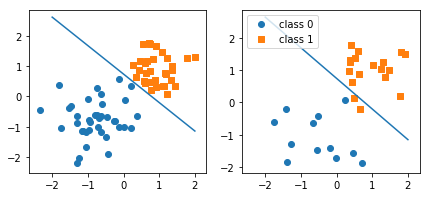

In [12]:
x_min = -2
y_min = ( -(model_params['weights'][0] * x_min) / model_params['weights'][1]
          -(model_params['bias'] / model_params['weights'][1]) )

x_max = 2
y_max = ( -(model_params['weights'][0] * x_max) / model_params['weights'][1]
          -(model_params['bias'] / model_params['weights'][1]) )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

- Suggested exercises


1. Train a zero-weight perceptron with different learning rates and compare the model parameters and decision boundaries to each other. What do you observe?

2. Repeat the previous exercise with randomly initialized weights.

In [13]:
# %load solutions/01_weight_zero_learning_rate.py

In [14]:
# %load solutions/02_random_weights_learning_rate.py

## Implementing a Perceptron in TensorFlow

- Setting up the perceptron graph

In [16]:
g = tf.Graph()


n_features = X_train.shape[1]

with g.as_default() as g:
    
    # initialize model parameters
    features = tf.placeholder(dtype=tf.float32, 
                              shape=[None, n_features], name='features')
    targets = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 1], name='targets')
    params = {
        'weights': tf.Variable(tf.zeros(shape=[n_features, 1], 
                                        dtype=tf.float32), name='weights'),
        'bias': tf.Variable([[0.]], dtype=tf.float32, name='bias')}
    
    # forward pass
    linear = tf.matmul(features, params['weights']) + params['bias']
    ones = tf.ones(shape=tf.shape(linear)) 
    zeros = tf.zeros(shape=tf.shape(linear))
    prediction = tf.where(tf.less(linear, 0.), zeros, ones, name='prediction')
    
    # weight update
    diff = targets - prediction
    weight_update = tf.assign_add(params['weights'], 
                                  tf.reshape(diff * features, (n_features, 1)))
    bias_update = tf.assign_add(params['bias'], diff)
    
    saver = tf.train.Saver()

- Training the perceptron for 5 training samples for illustration purposes

In [17]:
with tf.Session(graph=g) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    i = 0
    for example, target in zip(X_train, y_train):
        feed_dict = {features: example.reshape(-1, n_features),
                     targets: target.reshape(-1, 1)}
        _, _ = sess.run([weight_update, bias_update], feed_dict=feed_dict)
        
        i += 1
        if i >= 4:
            break
        

    modelparams = sess.run(params)    
    print('Model parameters:\n', modelparams)

    saver.save(sess, save_path='perceptron')
    
    pred = sess.run(prediction, feed_dict={features: X_train})
    errors = np.sum(pred.reshape(-1) != y_train)
    print('Number of training errors:', errors)

Model parameters:
 {'weights': array([[ 1.47257054],
       [ 0.30436274]], dtype=float32), 'bias': array([[-1.]], dtype=float32)}
Number of training errors: 3


- Continue training of the graph after restoring the session from a local checkpoint (this can be useful if we have to interrupt out computational session)
- Now train a complete epoch

In [18]:
with tf.Session(graph=g) as sess:
    saver.restore(sess, os.path.abspath('perceptron'))

    for epoch in range(1):
        for example, target in zip(X_train, y_train):
            feed_dict = {features: example.reshape(-1, n_features),
                         targets: target.reshape(-1, 1)}
            _, _ = sess.run([weight_update, bias_update], feed_dict=feed_dict)
            modelparams = sess.run(params)

    saver.save(sess, save_path='perceptron')
    
    pred = sess.run(prediction, feed_dict={features: X_train})
    train_errors = np.sum(pred.reshape(-1) != y_train)
    pred = sess.run(prediction, feed_dict={features: X_train})
    test_errors = np.sum(pred.reshape(-1) != y_train)

    print('Number of training errors', train_errors)
    print('Number of test errors', test_errors)

Number of training errors 0
Number of test errors 0


- Suggested Exercises


3) Plot the decision boundary for this TensorFlow perceptron. Why do you think the TensorFlow implementation performs better than our NumPy implementation on the test set?
 - Hint 1: you can re-use the code that we used in the NumPy section
 - Hint 2: since the bias is a 2D array, you need to access the float value via `modelparams['bias'][0]`
 

In [19]:
# %load solutions/03_tensorflow-boundary.py

- Theoretically, we could restart the Jupyter notebook now (we would just have to prepare the dataset again then, though)
- We are going to restore the session from a meta graph (notice "`tf.Session()`")
- First, we have to load the datasets again

In [20]:
with tf.Session() as sess:
    
    saver = tf.train.import_meta_graph(os.path.abspath('perceptron.meta'))
    saver.restore(sess, os.path.abspath('perceptron'))
    
    pred = sess.run('prediction:0', feed_dict={'features:0': X_train})
    train_errors = np.sum(pred.reshape(-1) != y_train)
    pred = sess.run('prediction:0', feed_dict={'features:0': X_test})
    test_errors = np.sum(pred.reshape(-1) != y_test)
    
    print('Number of training errors', train_errors)
    print('Number of test errors', test_errors)

Number of training errors 0
Number of test errors 0
